# Content
1. Transfer Learning
2. Multi Model Fusion
3. LIME for XAI

# Transfer Learning - Model Develop Approach

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define transformations for the datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Load the Fashion MNIST dataset
fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [4]:
# Create data loaders
batch_size = 1024
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=24)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
fashion_mnist_train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True, num_workers=24)
fashion_mnist_test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)


In [12]:
# Define a simple neural network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.cnn1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10) 
        

    def forward(self, x):
        x = nn.functional.relu(self.cnn1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.cnn2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 6 * 6)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        

# Initialize the model
model = SimpleCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# Train the model on the MNIST dataset
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    print(f'Accuracy: {100 * correct / total}%')
    return all_labels, all_preds

In [13]:
# Train the Source Model
train_model(model, fashion_mnist_train_loader, criterion, optimizer, 10)

Epoch 1, Loss: 1.5385930154283167
Epoch 2, Loss: 0.7681518186957149
Epoch 3, Loss: 0.6346511911537688
Epoch 4, Loss: 0.573264335171651
Epoch 5, Loss: 0.5349920139474383
Epoch 6, Loss: 0.5035997659473096
Epoch 7, Loss: 0.4842619426169638
Epoch 8, Loss: 0.4622913705090345
Epoch 9, Loss: 0.44603687726845176
Epoch 10, Loss: 0.4328203236652633


In [17]:
# Transfer learning: Fine-tune the model on the MNIST dataset
# Freeze the convolutional layers
for param in model.cnn1.parameters():
    param.requires_grad = False
for param in model.cnn2.parameters():
    param.requires_grad = False

# Reinitialize the optimizer to optimize only the fully connected layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [18]:
# Train the model on the MNIST dataset
train_model(model, mnist_train_loader, criterion, optimizer, 15)

Epoch 1, Loss: 2.743747703099655
Epoch 2, Loss: 1.1490873401447879
Epoch 3, Loss: 0.7156231241711115
Epoch 4, Loss: 0.5381793465654728
Epoch 5, Loss: 0.4409950527094178
Epoch 6, Loss: 0.3784464688624366
Epoch 7, Loss: 0.3343746035785998
Epoch 8, Loss: 0.301404548398519
Epoch 9, Loss: 0.275808535137419
Epoch 10, Loss: 0.25442286517660495
Epoch 11, Loss: 0.2369197680283401
Epoch 12, Loss: 0.22272868201894275
Epoch 13, Loss: 0.20990096108388093
Epoch 14, Loss: 0.19867927088575849
Epoch 15, Loss: 0.18879202765933537


In [19]:
all_labels, all_preds = evaluate_model(model, mnist_test_loader)

Accuracy: 95.42%


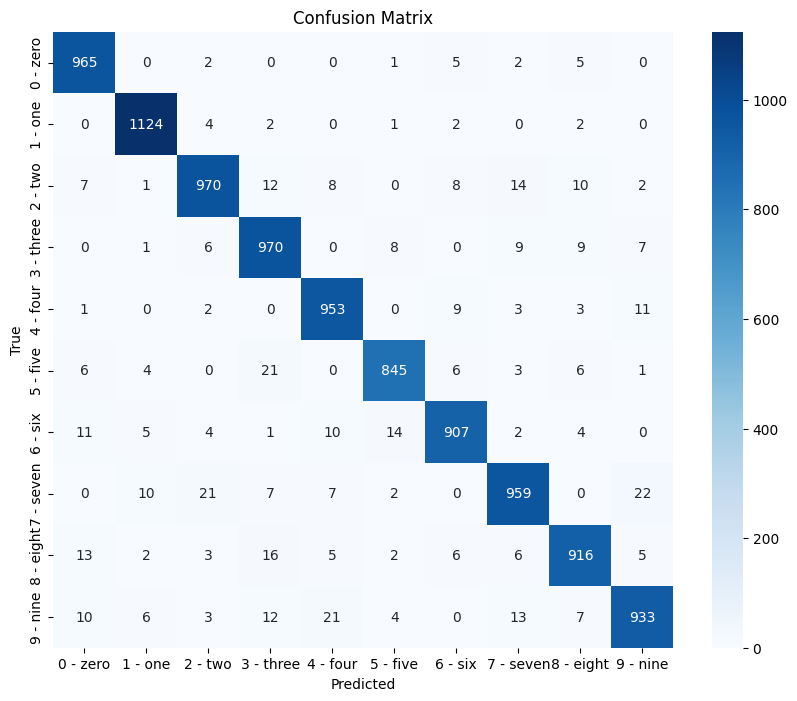

In [20]:
# Visualize the confusion matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = mnist_test.classes
plot_confusion_matrix(all_labels, all_preds, class_names)

# Multi Model Fusion

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import DataLoader, random_split
import os
import librosa
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
# Define paths
root_dir = '/home/ubuntu/data/projects/csc6203/data'
batch_size = 512
num_epochs = 5
learning_rate = 0.0001

target_sample_rate = 16000
max_length = 16000  # 1 second

In [24]:
# Load the SpeechCommands dataset
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__(root=root_dir, download=True)
        def load_list(filename):
            with open(filename) as f:
                x =  [os.path.join(self._path, line.strip()) for line in f]
                return x
        if subset == "validation":
            self._walker = load_list(self._path  + "/validation_list.txt")
        elif subset == "testing":
            self._walker = load_list(self._path + "/testing_list.txt")
        elif subset == "training":
            excludes = load_list(self._path + "/validation_list.txt") + load_list(self._path + "/testing_list.txt")
            self._walker = [w for w in self._walker if w not in excludes]

In [35]:
train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

labels = sorted(list(set(datapoint[2] for datapoint in val_set)))
label_to_index = {label: i for i, label in enumerate(labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

In [41]:
l2i = {label: i for i, label in enumerate(labels)}

In [45]:
def label_to_index(word):
    return labels.index(word)

def collate_fn(batch):
    w_tensors, m_tensors, targets = [], [], []

    for waveform, sample_rate, label, *_ in batch:
        if sample_rate != target_sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)
        if waveform.size(1) > max_length:
            waveform = waveform[:, :max_length]
        elif waveform.size(1) < max_length:
            waveform = torch.nn.functional.pad(waveform, (0, max_length - waveform.size(1)))

        mfcc = torch.Tensor(librosa.feature.mfcc(y=waveform.numpy(), sr=target_sample_rate))
        
        w_tensors.append(waveform)
        m_tensors.append(mfcc)
        targets.append(l2i[label])

    w_tensors = torch.stack(w_tensors)
    m_tensors = torch.stack(m_tensors)
    targets = torch.tensor(targets)
    return m_tensors, w_tensors, targets


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=16)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8)

In [57]:
# Define the CNN for audio features
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 7, 128)
        self.fc2 = nn.Linear(128, 64)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class AudioRNN(nn.Module):
    def __init__(self):
        super(AudioRNN, self).__init__()
        self.rnn1 = nn.RNN(input_size=16000, hidden_size=1024, num_layers=2, batch_first=True)
        self.rnn2 = nn.RNN(input_size=1024, hidden_size=512, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)


    def forward(self, x):
        x, _ = self.rnn1(x)
        x = F.relu(x)
        x, _ = self.rnn2(x)
        x = F.relu(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
    
# Define the fusion model
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.audio_cnn = AudioCNN()
        self.audio_rnn = AudioRNN()
        self.fc = nn.Linear(64 + 64, 35) 
        

    def forward(self, mfcc, waveform):
        audio_cnn_features = self.audio_cnn(mfcc)
        audio_rnn_features = self.audio_rnn(waveform).squeeze()

        combined_features = torch.cat((audio_cnn_features, audio_rnn_features), dim=1)
        output = self.fc(combined_features)
        return output
        

In [58]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model, loss function, and optimizer
model = FusionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (mfcc, waveform, target) in enumerate(train_loader):
        mfcc, waveform, target = mfcc.to(device), waveform.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(mfcc, waveform)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(waveform)}/{len(train_loader.dataset)}]\tLoss: {loss.item()}')

# Validation function
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for mfcc, waveform, target in val_loader:
            mfcc, waveform, target = mfcc.to(device), waveform.to(device), target.to(device)
            output = model(mfcc, waveform)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)')

# Evaluate the model
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for mfcc, waveform, target in test_loader:
            mfcc, waveform, target = mfcc.to(device), waveform.to(device), target.to(device)
            output = model(mfcc, waveform)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(15,15))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, include_values=False)
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.0f}%)')
    plt.show()


Train Epoch: 1 [0/84843]	Loss: 4.8237996101379395
Train Epoch: 1 [51200/84843]	Loss: 2.8519861698150635
Validation set: Average loss: 0.0049, Accuracy: 3628/9981 (36%)
Train Epoch: 2 [0/84843]	Loss: 2.412989854812622
Train Epoch: 2 [51200/84843]	Loss: 2.0497665405273438
Validation set: Average loss: 0.0036, Accuracy: 5191/9981 (52%)
Train Epoch: 3 [0/84843]	Loss: 1.722452163696289
Train Epoch: 3 [51200/84843]	Loss: 1.6048564910888672
Validation set: Average loss: 0.0030, Accuracy: 5816/9981 (58%)
Train Epoch: 4 [0/84843]	Loss: 1.4563860893249512
Train Epoch: 4 [51200/84843]	Loss: 1.345287561416626
Validation set: Average loss: 0.0028, Accuracy: 6061/9981 (61%)
Train Epoch: 5 [0/84843]	Loss: 0.9976989030838013
Train Epoch: 5 [51200/84843]	Loss: 0.8994461894035339
Validation set: Average loss: 0.0031, Accuracy: 5824/9981 (58%)
Test set: Average loss: 0.0033, Accuracy: 6154/11005 (56%)


<Figure size 1500x1500 with 0 Axes>

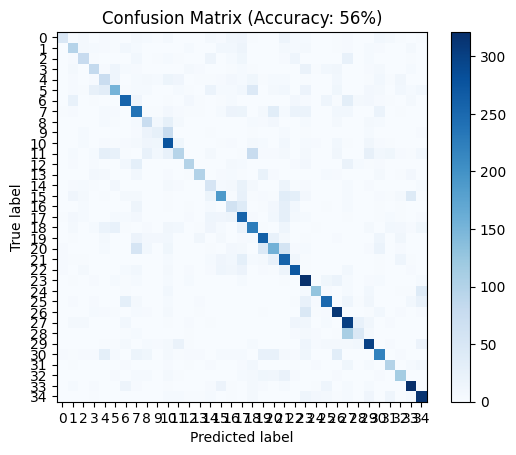

In [59]:
# Train and validate the model
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    validate(model, device, val_loader)

test(model, device, test_loader)


# XAI - LIME

In [61]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

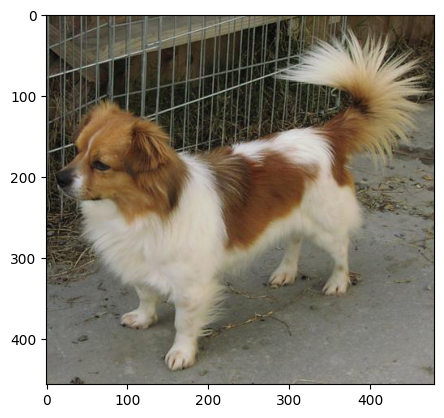

In [63]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('/home/ubuntu/data/projects/csc6203/PetImages_lite/Dog/181.jpg')
plt.imshow(img)

In [64]:
# resize image
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [65]:
# Load the Model
model = models.inception_v3(weights=True)

/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [66]:
# Load the Inception Class Index
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}   

In [67]:
# Try-out for single image
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [68]:
# Get the softmax of the logits to get probabilities and class labels for top 5
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.9845517, 157, 'papillon'),
 (0.012280494, 152, 'Japanese_spaniel'),
 (0.0027582522, 156, 'Blenheim_spaniel'),
 (0.0002969297, 154, 'Pekinese'),
 (3.7221616e-05, 230, 'Shetland_sheepdog'))

In [69]:
# Transform for batch prediction
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [70]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [71]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

157

In [72]:
from lime import lime_image

In [73]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
from skimage.segmentation import mark_boundaries

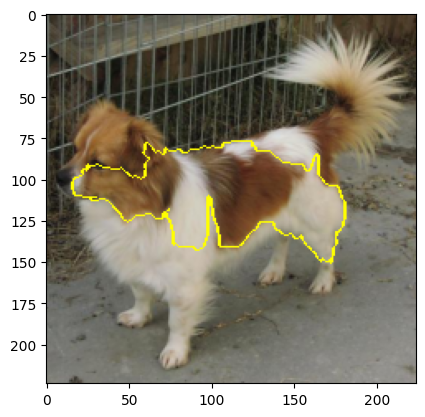

In [75]:
# Mark the areas that encourage the prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

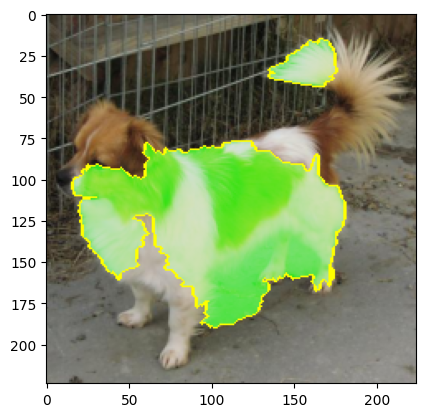

In [76]:
# Mark the areas that contributes against the top prediction

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)